In [1]:
from pdrtpy.modelset import ModelSet
import numpy as np
from astropy.table import Table
import pdrtpy.pdrutils as util
from pdrtpy.plot.lineratioplot import LineRatioPlot
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.modelplot import ModelPlot
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
from pdrtpy import version
from astropy.nddata import StdDevUncertainty
import astropy.units as u
%matplotlib inline

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [2]:
m = ModelSet(name="wk2006",z=1)

In [3]:
version()

'2.0.7-i'

In [4]:
m.table.show_in_notebook()

idx,numerator,denominator,ratio,filename,z,title
,,,,,,null
0,OI_145,OI_63,OI_145/OI_63,oioiweb,1.0,[O I] 145 $\mu$m / [O I] 63 $\mu$m
1,OI_145,CII_158,OI_145/CII_158,o145ciiweb,1.0,[O I] 145 $\mu$m / [C II] 158 $\mu$m
2,OI_63,CII_158,OI_63/CII_158,oicpweb,1.0,[O I] 63 $\mu$m / [C II] 158 $\mu$m
3,CII_158,CI_609,CII_158/CI_609,ciici609web,1.0,[C II] 158 $\mu$m / [C I] 609 $\mu$m
4,CI_370,CI_609,CI_370/CI_609,ciciweb,1.0,[C I] 370 $\mu$m / [C I] 609 $\mu$m
5,CII_158,CO_10,CII_158/CO_10,ciicoweb,1.0,[C II] 158 $\mu$m / CO(J=1-0)
6,CII_158,CO_32,CII_158/CO_32,ciico32web,1.0,[C II] 158 $\mu$m / CO(J=3-2)
7,CI_609,CO_10,CI_609/CO_10,cicoweb,1.0,[C I] 609 $\mu$m / CO(J=1-0)
8,CI_609,CO_21,CI_609/CO_21,cico21web,1.0,[C I] 609 $\mu$m / CO(J=2-1)


In [5]:
mp = ModelPlot(m)
'H264Q11/H210S1' in m.table['ratio']

True

In [6]:
try:
    m.model_ratios(["CII_158"])
except Exception as e:
    print("caught exception properly:",e)

mz = m.get_model('CII_158/CI_609')
mz.data.max()

caught exception properly: m most contain at least two strings


7066.33

In [7]:
try:
    m.get_models(['CII_158'],model_type='foo')
except ValueError as e:
    print("caught exception properly ",e)
x=m.get_models(["CI_609","FIR"],model_type="ratio")
y=m.get_models(["CI_609","FIR"],model_type="intensity")
z=m.get_models(["CI_609","FIR"],model_type="both")
q=m.get_models(['CII_158'],model_type='intensity')

caught exception properly  Unrecognized model_type: must be one of 'intensity', 'ratio', or 'both'
INFO: using the unit erg / (cm2 s sr) passed to the FITS reader instead of the unit erg s-1 cm-2 sr-1 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit erg / (cm2 s sr) passed to the FITS reader instead of the unit erg s-1 cm-2 sr-1 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit erg / (cm2 s sr) passed to the FITS reader instead of the unit erg s-1 cm-2 sr-1 in the FITS file. [astropy.nddata.ccddata]


dict: {'CI_609': [1.5e-06] +/- 5e-07 erg / (cm2 s sr), 'CII_158/CI_609': [2] +/- 1 erg / (cm2 s sr), 'CII_158': [3.e-06] +/- 5e-07 erg / (cm2 s sr)}
<class 'pdrtpy.measurement.Measurement'>
INFO: using the unit erg / (cm2 s sr) passed to the FITS reader instead of the unit erg s-1 cm-2 sr-1 in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit erg / (cm2 s sr) passed to the FITS reader instead of the unit erg s-1 cm-2 sr-1 in the FITS file. [astropy.nddata.ccddata]


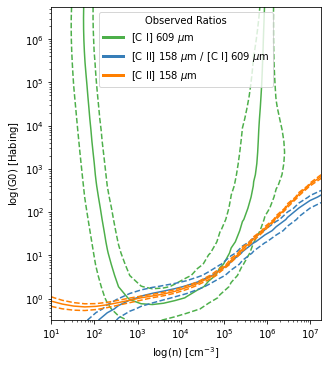

In [10]:
myunit = "erg s-1 cm-2 sr-1"
mx=Measurement(data=[1.5E-6],uncertainty = StdDevUncertainty(0.5E-6),identifier="CI_609",unit=myunit)
my=Measurement(data=[2],uncertainty = StdDevUncertainty(1),identifier="CII_158/CI_609",unit=myunit)
mz=Measurement(data=[3E-6],uncertainty = StdDevUncertainty(0.5E-6),identifier="CII_158",unit=myunit)
a=[mx,my,mz]
ids = [m.id for m in a]
d = dict(zip(ids,a))
print("dict:",d)
print(type(d["CI_609"]))
d["CI_609"].levels
mp.overlay(a)
#q[1].id

In [ ]:
mp.plot("CI_609",measurements=[mx],image=False,legend=True,contours=True,yaxis_unit=u.erg/(u.second*u.cm*u.cm),label=True)

In [ ]:
mp.plot("CI_609/FIR",image=True,measurements=[mx],legend=True,axis_unit=u.erg/(u.second*u.cm*u.cm),label=True)

In [ ]:
mp.plot(["CI_609/FIR","CII_158/CI_609"],image=True,measurements=[mx,my],legend=True,axis_unit=u.erg/(u.second*u.cm*u.cm),label=False)

In [ ]:
l = LineRatioFit(m,[mx])

In [ ]:
p = LineRatioPlot(l)

In [ ]:
l.modelset.supported_ratios.show_in_notebook()

In [ ]:
p.modelintensity("CI_609",measurements=[mx],legend=True,contours=True,yaxis_unit=u.erg/(u.second*u.cm*u.cm),label=True)